In [1]:
%matplotlib inline

from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm



In [95]:
# https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
# http://www.jcreview.com/fulltext/197-1593940464.pdf?1605285118

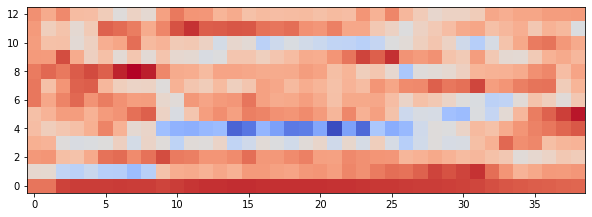

In [92]:
(rate,sig) = wav.read("Data/WOMAN/SP/2B_endpt.wav")
mfcc_feat = mfcc(sig[:3200],rate)
fig, ax = plt.subplots(figsize=(10,10))
mfcc_feat= np.swapaxes(mfcc_feat, 0 ,1)
cax = ax.imshow(mfcc_feat, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

plt.show()

In [93]:
sig.shape

(4880,)

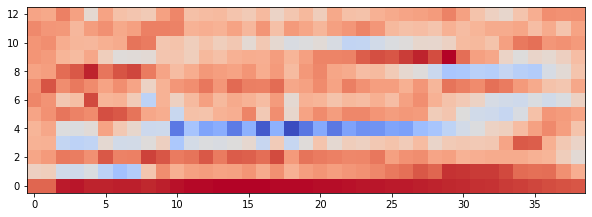

In [94]:
(rate,sig) = wav.read("Data/WOMAN/SP/2A_endpt.wav")
mfcc_feat = mfcc(sig,rate)
fig, ax = plt.subplots(figsize=(10,10))
mfcc_feat= np.swapaxes(mfcc_feat, 0 ,1)
cax = ax.imshow(mfcc_feat, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

plt.show()

In [91]:
sig.shape

(3200,)

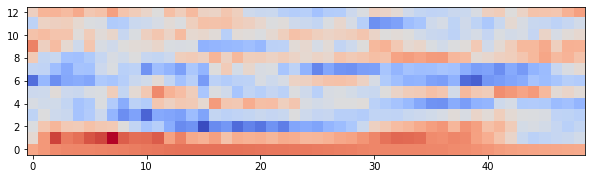

In [86]:
(rate,sig) = wav.read("Data/WOMAN/SP/1A_endpt.wav")
mfcc_feat = mfcc(sig,rate)
fig, ax = plt.subplots(figsize=(10,10))
mfcc_feat= np.swapaxes(mfcc_feat, 0 ,1)
cax = ax.imshow(mfcc_feat, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

plt.show()

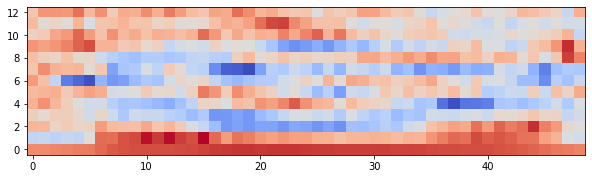

In [87]:
(rate,sig) = wav.read("Data/WOMAN/SP/1B_endpt.wav")
mfcc_feat = mfcc(sig,rate)
fig, ax = plt.subplots(figsize=(10,10))
mfcc_feat= np.swapaxes(mfcc_feat, 0 ,1)
cax = ax.imshow(mfcc_feat, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

plt.show()

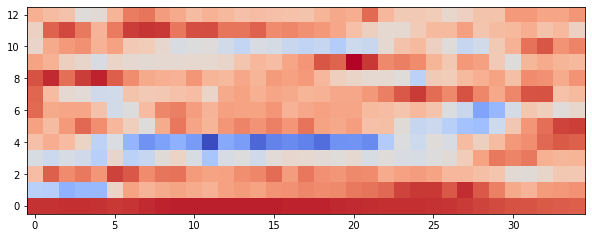

In [111]:
(rate,sig) = wav.read("/tmp/2B_endpt_cut.wav")
mfcc_feat1 = mfcc(sig,rate)
fig, ax = plt.subplots(figsize=(10,10))
mfcc_feat1= np.swapaxes(mfcc_feat1, 0 ,1)
cax = ax.imshow(mfcc_feat1, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

plt.show()

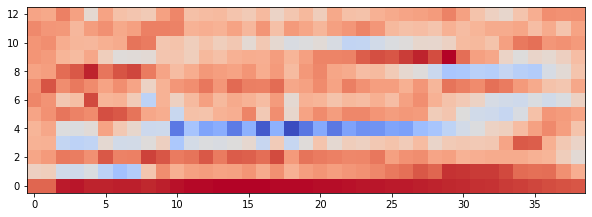

In [112]:
(rate,sig) = wav.read("Data/WOMAN/SP/2A_endpt.wav")
mfcc_feat2 = mfcc(sig,rate)
fig, ax = plt.subplots(figsize=(10,10))
mfcc_feat2= np.swapaxes(mfcc_feat2, 0 ,1)
cax = ax.imshow(mfcc_feat2, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

plt.show()

-0.044643737388443974


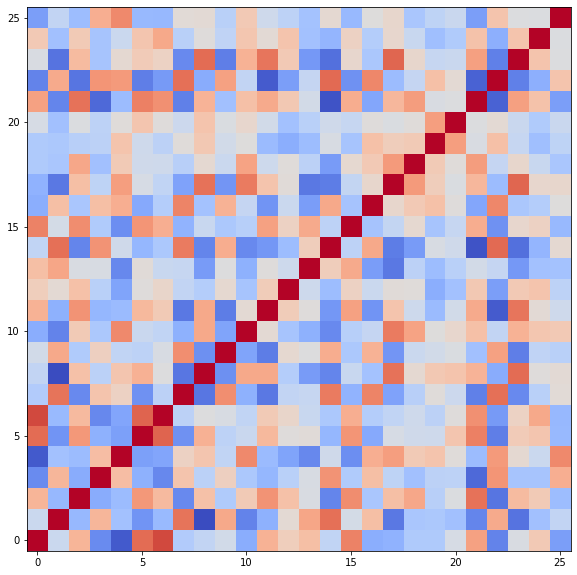

In [141]:
pearson = np.corrcoef(mfcc_feat1[:, :30], mfcc_feat2[:, :30])
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(pearson, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

print(pearson[0, 1])

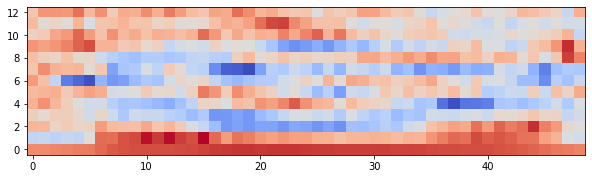

In [138]:
(rate,sig) = wav.read("Data/WOMAN/SP/1B_endpt.wav")
mfcc_feat0 = mfcc(sig,rate)
fig, ax = plt.subplots(figsize=(10,10))
mfcc_feat0 = np.swapaxes(mfcc_feat0, 0 ,1)
cax = ax.imshow(mfcc_feat0, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

plt.show()

0.6614167270690865


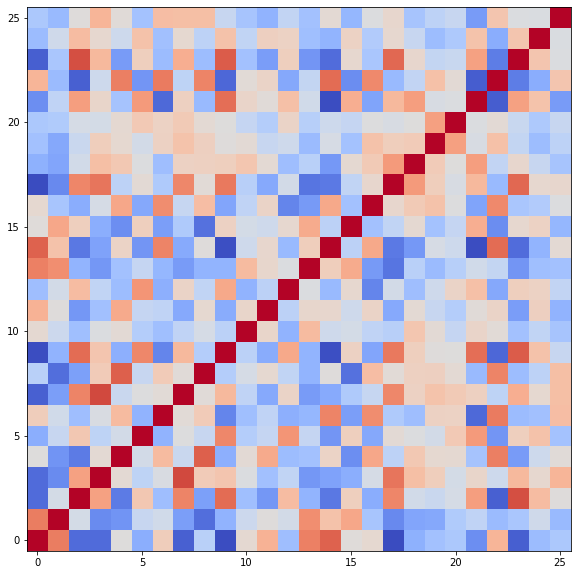

In [148]:
pearson = np.corrcoef(mfcc_feat0[:, :30], mfcc_feat2[:, :30])
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(pearson, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
print(pearson[0, 1])

In [149]:
pearson.shape

(26, 26)